In [1294]:
import warnings
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [996]:
# Kenya Dataset
df = pd.read_excel("../data/kenya.xlsx")

# Ugandan Dataset
df1 = pd.read_excel("../data/uganda.xlsx")

# Tanzanian Dataset
df2 = pd.read_excel("../data/tanzania.xlsx")

### Function to clean our data

In [999]:
child_indicators = [
    'Careseeking for diarrhoea - percentage of children (under age 5) with diarrhoea for whom advice or treatment was sought from a health facility or provider',
    'Careseeking for febrile children - percentage of children (under age 5) with fever for whom advice or treatment was sought from a health facility or provider',
    'ITN use by children - percentage of children (under age 5) who slept under an insecticide-treated mosquito net the night prior to the survey',
    'Malaria diagnostics - percentage of febrile children (under age 5) who had a finger or heel stick for malaria testing',
    'Malaria, first line treatment - percentage of febrile children (under age 5) receiving ACT (first line antimalarial drug), among those receiving any antimalarial drugs',
    'Diarrhoea treatment - percentage of children (under age 5) with diarrhoea who received ORS (packets or pre-packaged fluids)',
    'Diarrhoea treatment - percentage of children (under age 5) with diarrhoea who received ORS and zinc',
    'Diarrhoea treatment - percentage of children (under age 5) with diarrhoea who received ORT (oral rehydration salts or recommended homemade fluids or increased fluids) and continued feeding',
    'Diarrhoea treatment - percentage of children (under age 5) with diarrhoea who received zinc',
    'Postnatal care for newborns - percentage of newborns who have a postnatal contact with a health provider within 2 days of delivery',
    'Careseeking for ARI - percentage of children (under age 5) with acute respiratory infection symptoms whom advice or treatment was sought from a health facility or provider',
    # 'Percentage of adolescents (aged 15-19 years) who had at least one alcoholic drink at any time during the last 12 months',
    'Life expectancy at birth - number of years newborn female children would live if subject to the mortality risks prevailing for the cross section of population at the time of their birth (estimated)',
    # 'Percentage of adolescents (aged 13-15 years) who smoked cigarettes or used smoked or smokeless tobacco products at any time during the last month',
    # 'Insufficient physical activity among school going adolescents'
]

mother_indicators = [
    'Adolescent birth rate (number of live births to adolescent women per 1,000 adolescent women)',
    'Antenatal care 1+ visit - percentage of women (aged 15-49 years) attended at least once during pregnancy by skilled health personnel',
    'Antenatal care 4+ visits - percentage of women (aged 15-49 years) attended at least four times during pregnancy by any provider',
    'Early childbearing - percentage of women (aged 20-24 years) who gave birth before age 18',
    'C-section rate - percentage of deliveries by cesarean section',
    'Demand for family planning satisfied with modern methods - percentage of women (aged 15-49 years)',
    'IPTp for pregnant women - percentage of women (aged 15-49 years) who received three or more doses of intermittent preventive treatment during antenatal care visits during their last pregnancy',
    'Pregnant women sleeping under ITN - percentage of pregnant women (aged 15-49 years) who slept under an insecticide-treated net the previous night',
    'Lifetime risk of maternal death (probability (1 in X) that a 15-year-old girl (in the year of the estimate) will eventually die from a maternal cause)',
    'Maternal deaths (estimated)',
    'Maternal mortality ratio (number of maternal deaths per 100,000 live births)',
    'Postnatal care for mothers - percentage of women (aged 15-49 years) who received postnatal care within 2 days of giving birth',
    'Skilled birth attendant - percentage of deliveries attended by skilled health personnel',
    'Universal health coverage index for reproductive, maternal, newborn and child-health interventions',
    'Institutional deliveries - percentage of deliveries in a health facility',
]


In [1001]:
def clean_dataset(df):

    # Clean column names
    df.columns = [col.strip().replace(" ", "_").lower() for col in df.columns]

    # Keep only relevant columns
    relevant_cols = [
        "geographic_area", "indicator", "sex", "current_age", "wealth_quintile",
        "residence", "mother's_education_level", "time_period", 
        "obs_value", "sub_sector"
    ]
    df = df[relevant_cols]

    # Standardize categorical values
    cat_cols = ["wealth_quintile", "residence", "mother's_education_level"]
    for col in cat_cols:
        df[col] = df[col].astype(str).str.strip().str.lower()

    # Step 1: Define a function to assign category
    def assign_category(desc):
        if desc in child_indicators:
            return "child"
        elif desc in mother_indicators:
            return "mother"
        else:
            return None  # or "other"

    # Step 2: Apply function to create new column
    df["category"] = df["indicator"].apply(assign_category)
    
    # Step 3: Filter to keep only child or mother
    df = df[df["category"].isin(["child", "mother"])].copy()

    # Generate short labels for each unique indicator
    unique_indicators = df["indicator"].unique()
    short_labels = [f"indicator_{i+1}" for i in range(len(unique_indicators))]

    # Create mapping: short_label -> full description
    indicator_mapping_df = pd.DataFrame({
        "short_label": short_labels,
        "full_description": unique_indicators
    })

    # Create reverse mapping: full_description -> short_label
    reverse_mapping = dict(zip(unique_indicators, short_labels))

    # Replace long indicator with short label
    df["indicator"] = df["indicator"].map(reverse_mapping)

    # Convert to categorical
    df["indicator"] = df["indicator"].astype("category")

    # Drop NaNs and duplicates
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)

    # Sort by time
    df.sort_values("time_period", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Assign risk categories by indicator
    def assign_risk_by_indicator(subdf):
        q75 = subdf['obs_value'].quantile(0.75)
        q25 = subdf['obs_value'].quantile(0.25)
        def get_risk(value):
            if value >= q75:
                return 'High'
            elif value >= q25:
                return 'Medium'
            else:
                return 'Low'
        subdf['risk_category'] = subdf['obs_value'].apply(get_risk)
        return subdf

    df = df.groupby('indicator', group_keys=False).apply(assign_risk_by_indicator)

    return df


In [1003]:
# Kenyan Dataset with Metadata (Indicator)
data = clean_dataset(df)

# Ugandan Dataset with Metadata (Indicator)
data1 = clean_dataset(df1)

# Tanzanian Dataset with Metadata (Indicator)
data2 = clean_dataset(df2)

# Combined the cleaned datasets
comb_data = pd.concat([data, data1, data2])

# Save to .csv file
comb_data.to_csv("../data/combined_eac_maternal.csv", index=False)

### Exploratory Data Analysis

In [1096]:
df = pd.read_csv("../data/combined_eac_maternal.csv")

In [1098]:
# Segment data to respectful categories "mother" and "child"
mother_df = df[df["category"] == "mother"]
child_df = df[df["category"] == "child"]

# Delete unnecessary features
child_df.drop(columns="category", inplace=True)
mother_df.drop(columns="category", inplace=True)

# Save to .csv file
mother_df.to_csv("../data/mother.csv", index=False)
child_df.to_csv("../data/child.csv", index=False)

### Child Data Analysis

In [1069]:
print(f"Duplicate Rows in Child Dataset: {child_df.duplicated().sum()}")
print(f"Duplicate Rows in Mother Dataset: {mother_df.duplicated().sum()}")

Duplicate Rows in Child Dataset: 1120
Duplicate Rows in Mother Dataset: 23


In [1076]:
# Delete the duplicated values
child_df.drop_duplicates(inplace=True)
mother_df.drop_duplicates(inplace=True)

In [1102]:
# Obs_Value over the years
child_df.head()

,geographic_area,indicator,sex,current_age,wealth_quintile,residence,mother's_education_level,time_period,obs_value,sub_sector,risk_category
0,Kenya,indicator_7,Total,Under 5 years old,total,total,secondary and higher,2000,8.5,DIAR,Low
1,Kenya,indicator_19,Total,Under 5 years old,middle,total,total,2000,33.5,DIAR,Low
2,Kenya,indicator_19,Total,Under 5 years old,fourth,total,total,2000,48.4,DIAR,Medium
3,Kenya,indicator_19,Total,Under 5 years old,highest,total,total,2000,46.6,DIAR,Medium
4,Kenya,indicator_10,Total,Under 5 years old,total,total,total,2000,3.0,MALA,Low


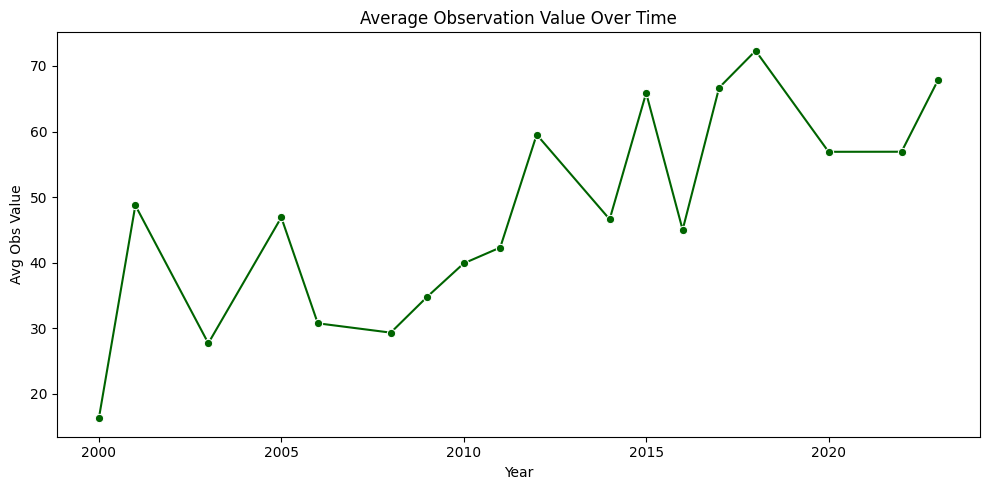

In [1120]:
# Group by year
avg_yearly = child_df.groupby("time_period")["obs_value"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_yearly, x="time_period", y="obs_value", marker="o", color="darkgreen")
plt.title("Average Observation Value Over Time")
plt.ylabel("Avg Obs Value")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


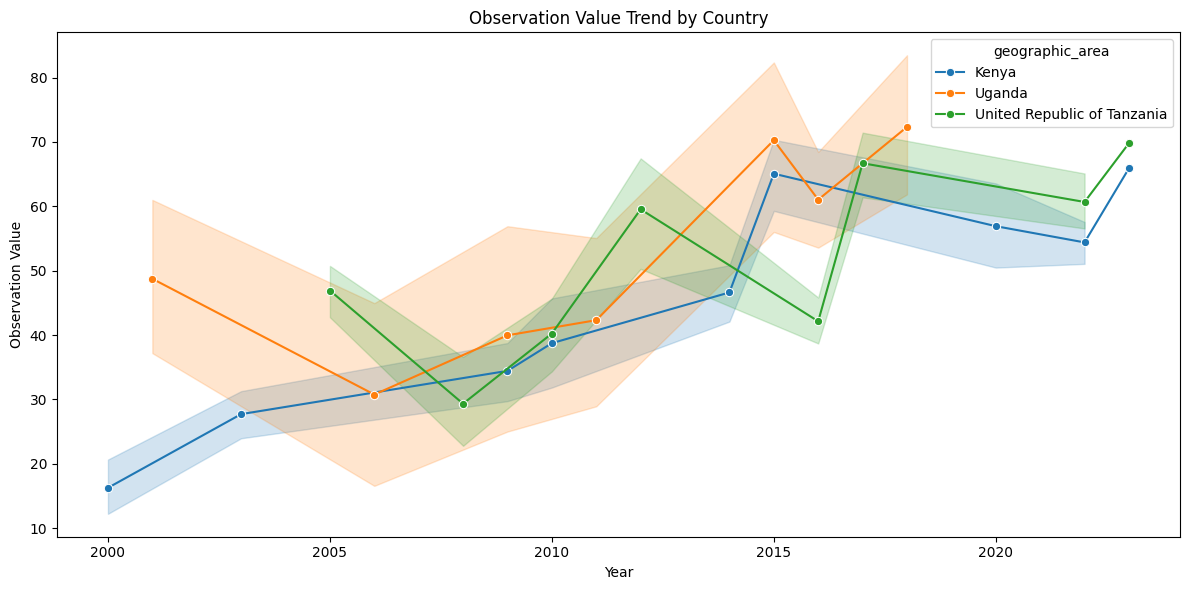

In [1124]:
# Plot trend by risk category
plt.figure(figsize=(12, 6))
sns.lineplot(data=child_df, x="time_period", y="obs_value", hue="geographic_area", marker="o")
plt.title("Observation Value Trend by Country")
plt.xlabel("Year")
plt.ylabel("Observation Value")
plt.tight_layout()
plt.show();

In [1222]:
# Risk Category Distribution (by Country) ---
print("\n. Risk Category Distribution by Country:")
risk_dist_country = child_df.groupby(['geographic_area', 'risk_category']).size().unstack(fill_value=0)
print(risk_dist_country)


2. Risk Category Distribution by Country:
risk_category                High  Low  Medium
geographic_area                               
Kenya                         137  131     258
Uganda                         24   24      38
United Republic of Tanzania   116  114     213


## Observation

### High-Risk Country Focus
<b>Kenya</b> and <b>Tanzania</b> contribute the highest number of high-risk cases:

Kenya: 137 | Tanzania: 116 | Uganda: 24

<b><i>Recommendation<i/></b>: Prioritize intervention resources (vaccination, sanitation, education programs) in Kenya and Tanzania.

In [1225]:
# Risk by Mother's Education ---
print("\n. Risk Category vs. Mother's Education Level:")
education_risk = child_df.groupby("mother's_education_level")['risk_category'].value_counts().unstack(fill_value=0)
print(education_risk)


3. Risk Category vs. Mother's Education Level:
risk_category                                         High  Low  Medium
mother's_education_level                                               
never attended an education programme / no schooling     5    8      18
primary education                                        6    6      19
secondary and higher                                    10    4      15
total                                                  256  251     457


## Observation

### Education as a Strong Predictor
#### High-risk percentages by education level:

- Secondary and higher: 34.5%

- Primary education: 19.4%

- No schooling: 16.1%

<b><i>Recommendation<i/><b/>: Better-educated mothers report more high-risk conditions, possibly due to awareness and reporting bias, but the medium risk remains high even in low education groups.

#### Dual strategy:

- Increase access to education 
- Run awareness campaigns in low-education communities

In [1245]:
# Sub-sector Summary by Risk ---
print("\n. Sub-sector Risk Breakdown:")
sub_sector_summary = child_df.groupby('sub_sector')['risk_category'].value_counts().unstack()
print(sub_sector_summary)

plt.figure(figsize=(10, 6))
sns.countplot(data=child_df, x='risk_category', hue='sub_sector')
plt.title("Distribution of Risk Categories by Sub-sector")
plt.xlabel("Risk Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


4. Sub-sector Risk Breakdown:
risk_category    High    Low  Medium
sub_sector                          
DEMOGRAPHY        2.0    NaN     NaN
DIAR            116.0  113.0   212.0
MALA            127.0  124.0   239.0
PNEU             19.0   19.0    35.0
POSTNATAL_CARE   13.0   13.0    23.0


## Observation

- `DIAR (Diarrhea)` and `MALA (Malaria)` have the highest counts across all risk levels, indicating more data and possibly greater public health concern.

- `PNEU (Pneumonia)` and `POSTNATAL_CARE` have fewer observations but still span all risk categories.

- `DEMOGRAPHY` only has data in the High risk category, suggesting limited or focused data in this area.

In [1274]:
# Diarrhea Rates by Wealth Quintile (All Countries, All Years
print("\n. 💰 Diarrhea Rates by Wealth Quintile (All Countries, All Years):")
filtered_diar = child_df[
    (child_df['sub_sector'] == 'DIAR') & 
    (child_df['wealth_quintile'] != 'total')
]

# Group by country, year, and wealth quintile, then calculate mean diarrhea rates
diar_by_wealth = filtered_diar.groupby(
    ['geographic_area', 'time_period', 'wealth_quintile']
)['obs_value'].mean().sort_index()

print(diar_by_wealth)


5. 💰 Diarrhea Rates by Wealth Quintile (All Countries, All Years):
geographic_area              time_period  wealth_quintile
Kenya                        2000         fourth             23.366667
                                          highest            23.966667
                                          lowest             19.433333
                                          middle             18.266667
                                          second             21.233333
                             2003         fourth             30.466667
                                          highest            37.833333
                                          lowest             29.800000
                                          middle             29.200000
                                          second             27.533333
                             2009         fourth             27.340000
                                          highest            31.075000
                      

## Observation

<b>General Pattern</b>: Across Kenya and Tanzania, diarrhea rates are not consistently lower among the wealthiest groups.

`Kenya`:

- From 2000 to 2014, wealthier quintiles (highest/fourth) generally had higher or similar diarrhea rates compared to poorer ones.

- By 2022, the lowest quintile had the highest rate (46.65), suggesting growing disparity or deteriorating conditions for the poor.

`Tanzania`:

- In 2005, wealthier groups had higher rates (e.g., highest: 57.5 vs lowest: 49.4).

- By 2022, the lowest quintile again had the highest rate (50.4), showing reversal of earlier patterns.

`Key Insight`: Wealth does not guarantee lower diarrhea rates consistently—other factors like access, sanitation, or urbanization may play stronger roles over time.

## Observation

### Wealth Inequality in Diarrhea
#### Diarrhea rates increase with wealth, peaking at highest quintile (39.3%)

- Counterintuitive — may reflect urban diet/hygiene changes or better detection

<b><i>Recommendation<i/><b/>:

- Investigate urban diarrhea causes

- Improve food safety and sanitation in wealthier regions, especially urban centers



In [1256]:
# 6a. 🏡 Urban vs Rural Diarrhea Rates (All Countries, All Years) - Exclude 'total'
print("\na. 🏡 Urban vs Rural Diarrhea Rates (All Countries, All Years):")
urban_diar_full = child_df[
    (child_df['sub_sector'] == 'DIAR') & 
    (child_df['residence'] != 'total')
].groupby(['geographic_area', 'time_period', 'residence'])['obs_value'].mean().unstack()
print(urban_diar_full)

# 6b. 🏡 Urban vs Rural Pneumonia Vaccination Rates (All Countries, All Years) - Exclude 'total'
print("\nb. 🏡 Urban vs Rural Pneumonia Vaccination Rates (All Countries, All Years):")
pneumo_full = child_df[
    (child_df['sub_sector'] == 'PNEU') & 
    (child_df['residence'] != 'total')
].groupby(['geographic_area', 'time_period', 'residence'])['obs_value'].mean().unstack()
print(pneumo_full)


6a. 🏡 Urban vs Rural Diarrhea Rates (All Countries, All Years):
residence                                    rural      urban
geographic_area             time_period                      
Kenya                       2000         24.133333  19.966667
                            2003         30.333333  32.866667
                            2009         25.960000  26.600000
                            2014         34.360000  39.380000
                            2022         40.650000  42.375000
Uganda                      2001         34.500000  47.133333
                            2006         30.000000  31.820000
                            2011         30.720000  33.220000
                            2016         45.600000  49.575000
United Republic of Tanzania 2005         51.133333  52.266667
                            2010         30.500000  32.160000
                            2016         31.480000  35.780000
                            2022         40.200000  40.700000

6b. 

## Observation

### 🔍 6a. Urban vs Rural Diarrhea Rates (All Countries, All Years)

#### 📌 Key Observations:
- Urban areas consistently have higher diarrhea rates than rural areas in Kenya (e.g., 2014: urban = 39.4%, rural = 34.4%).

- In Uganda, urban diarrhea rates are also consistently higher across all years, especially in 2001 (urban = 47.1%, rural = 34.5%).

- Tanzania follows a similar trend, though the difference is smaller in 2022 (urban = 40.7%, rural = 40.2%).

🧠 Interpretation:
This challenges the common assumption that rural areas always have worse sanitation. Urban areas in low-income countries may have higher population density and poor infrastructure (e.g., slums), increasing disease transmission.


### 6b. Urban vs Rural Pneumonia Vaccination Rates (All Countries, All Years)

#### 📌 Key Observations:
`Kenya`:

- Urban areas had higher vaccination coverage in 2003 and 2009 (e.g., 2009: urban = 65.5%, rural = 53.9%).

- By 2022, both urban and rural areas reached parity at 73%.

`Uganda`:

- Urban coverage has been consistently higher (e.g., 2011: urban = 80.8%, rural = 78.4%), though the gap is narrowing over time.

`Tanzania`:

- Urban coverage is also higher in all years, especially notable in 2010 (urban = 86.1%, rural = 65.3%).

#### 🧠 Interpretation:
- Urban areas likely benefit from better access to healthcare facilities, leading to higher vaccination rates.
- Over time, rural areas are catching up, indicating successful outreach and immunization programs.

In [1259]:
#📈 Diarrhea Rate Over Time (All Countries) ---
print("\n7. 📈 Diarrhea Rate Over Time (All Countries):")
diar_all = child_df[child_df['sub_sector'] == 'DIAR']
diar_time_trend_all = diar_all.groupby(['geographic_area', 'time_period'])['obs_value'].mean()
print(diar_time_trend_all)


7. 📈 Diarrhea Rate Over Time (All Countries):
geographic_area              time_period
Kenya                        2000           20.242424
                             2003           30.960606
                             2009           27.439623
                             2014           34.718644
                             2022           41.340385
Uganda                       2001           40.816667
                             2006           30.910000
                             2011           31.970000
                             2016           47.587500
United Republic of Tanzania  2005           51.366667
                             2010           29.505085
                             2016           32.059677
                             2022           40.886957
Name: obs_value, dtype: float64


## Observation

- All countries show non-linear trends, indicating varying intervention success or changes in data/reporting quality.

- Kenya shows the most consistent rise over time.

- Tanzania had the highest rate in 2005 but saw improvement before rising again.

- Uganda showed a sharp rise in 2016, needing further investigation.

`Kenya`
- There’s a general upward trend, suggesting diarrhea prevalence has increased over time.

`Uganda`
- Rates fluctuate, but there is a notable spike in 2016—possibly indicating worsening conditions or better detection/reporting.

`Tanzania`
- A significant drop from 2005 to 2010, followed by a resurgence in recent years.

In [1300]:
# Compute mean obs_value per indicator
indicator_means = child_df.groupby('indicator')['obs_value'].mean()

# Select top 5 indicators based on mean obs_value
top_10_indicators = indicator_means.sort_values(ascending=False).head(10).index.tolist()

# Filter original data to include only these top 5 indicators
top10_df = child_df[child_df['indicator'].isin(top_10_indicators)]

# Group by indicator and geographic_area, compute mean obs_value
top10 = top10_df.groupby(['indicator', 'geographic_area'])['obs_value'].mean().reset_index()


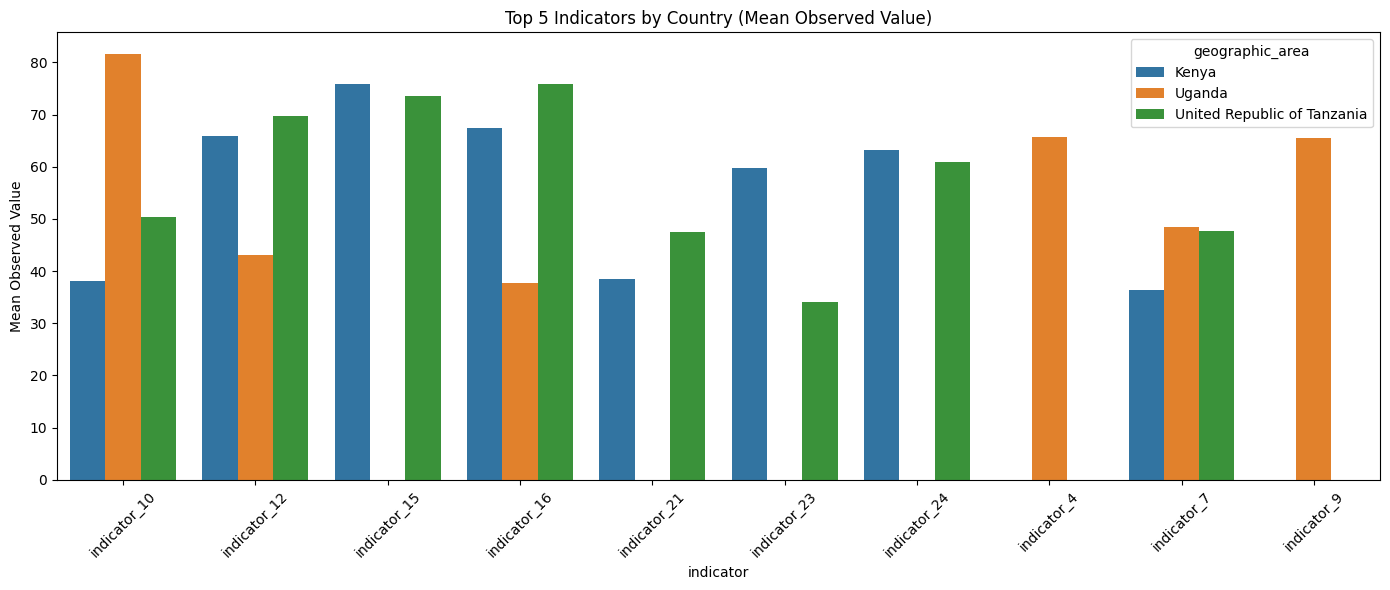

In [1302]:
plt.figure(figsize=(14, 6))
sns.barplot(data=top10, x='indicator', y='obs_value', hue='geographic_area')
plt.title("Top 5 Indicators by Country (Mean Observed Value)")
plt.ylabel("Mean Observed Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

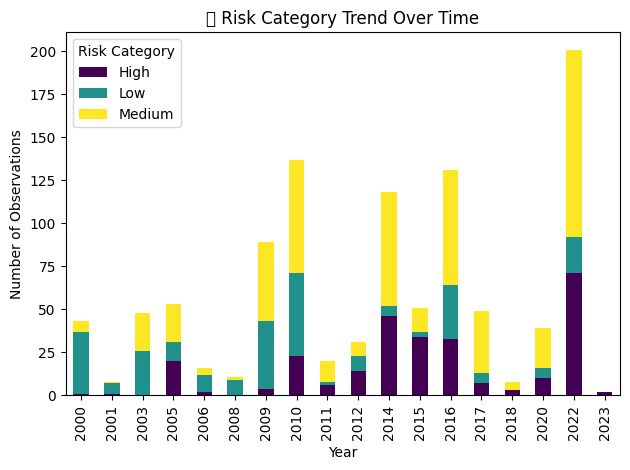

In [1306]:
# Group and pivot the data
risk_time = child_df.groupby(['time_period', 'risk_category']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
risk_time.plot(kind='bar', stacked=True, colormap='viridis')

plt.title('📊 Risk Category Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.legend(title='Risk Category')
plt.tight_layout();


---
This file &#169; 2025 by Jomo|Victoria|Taoheed [CSAAfrica](https://www.linkedin.com/company/csaafrica/posts/?feedView=all).